In [1]:
# Anda mungkin perlu menginstal library ini dulu
%pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pmdarima as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler

In [3]:
df = pd.read_csv("../Dataset/dataset-penduduk.csv")
print("Preview Dataset : ")
df.head(10)

Preview Dataset : 


,No,Tahun,Total,Laju Pertumbuhan,Kemiskinan,TFR,Angka Harapan Hidup
0,1,1961,97387000,2.1,58432200.0,6.64,47.30
1,2,1962,99257000,2.1,59554200.0,6.54,48.10
2,3,1963,101221000,2.1,60732600.0,6.44,48.70
3,4,1964,103271000,2.1,61962600.0,6.33,49.40
4,5,1965,105414000,2.1,63248400.0,6.23,42.76
5,6,1966,107645000,2.1,64587000.0,6.13,48.40
6,7,1967,109964000,2.1,65978400.0,6.02,51.30
7,8,1968,112377000,2.1,67426200.0,5.92,51.80
8,9,1969,114880000,2.1,68928000.0,5.82,52.58
9,10,1970,117469000,2.1,70000000.0,5.71,53.25


In [4]:
# Asumsikan 'df_populasi' adalah DataFrame Anda dengan kolom 'Total'
scaler = MinMaxScaler()
df['Total_normalized'] = scaler.fit_transform(df[['Total']])

# Bagi data menjadi training dan testing
train_size = int(len(df) * 0.85)
train_data = df['Total'][:train_size]
test_data = df['Total'][train_size:]

In [5]:


# # auto_arima akan mencari kombinasi (p,d,q) terbaik secara otomatis
# auto_model = pm.auto_arima(train_data,
#                            seasonal=False,
#                            stepwise=True,
#                            suppress_warnings=True,
#                            trace=True)

# print(auto_model.summary())
# # Output akan memberitahu Anda nilai (p,d,q) terbaik

In [6]:
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Abaikan warning yang mungkin muncul dari kombinasi yang tidak valid
warnings.filterwarnings("ignore")

# Asumsikan 'train_data' adalah data training Anda
# train_data = ...

# 1. Tentukan rentang p, d, q yang ingin diuji
p_values = range(0, 4)  # Coba p dari 0 hingga 3
d_values = range(1, 3)  # Coba d = 1 atau 2 (karena data populasi butuh differencing)
q_values = range(0, 4)  # Coba q dari 0 hingga 3

# 2. Siapkan variabel untuk menyimpan hasil terbaik
best_aic = float('inf')
best_order = None
best_model = None

# 3. Lakukan iterasi (looping) untuk setiap kombinasi
print("Memulai Grid Search...")
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                # Latih model ARIMA dengan kombinasi saat ini
                model = ARIMA(train_data, order=order)
                model_fit = model.fit()
                
                # Cek apakah AIC saat ini lebih baik (lebih kecil)
                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_order = order
                    best_model = model_fit
                    print(f"Ditemukan model baru yang lebih baik: ARIMA{order} dengan AIC={best_aic:.2f}")

            except:
                # Lanjutkan jika ada kombinasi yang menyebabkan error
                continue

print("\nGrid Search Selesai.")
print(f"Orde ARIMA terbaik adalah {best_order} dengan AIC={best_aic:.2f}")

Memulai Grid Search...
Ditemukan model baru yang lebih baik: ARIMA(0, 1, 0) dengan AIC=1778.29
Ditemukan model baru yang lebih baik: ARIMA(0, 1, 1) dengan AIC=1777.14
Ditemukan model baru yang lebih baik: ARIMA(0, 1, 2) dengan AIC=1777.05
Ditemukan model baru yang lebih baik: ARIMA(0, 2, 0) dengan AIC=1703.71
Ditemukan model baru yang lebih baik: ARIMA(1, 2, 1) dengan AIC=1703.25

Grid Search Selesai.
Orde ARIMA terbaik adalah (1, 2, 1) dengan AIC=1703.25


In [7]:
# best_order = (2,2,2)
# best_order

In [8]:
train_data

0      97387000
1      99257000
2     101221000
3     103271000
4     105414000
5     107645000
6     109964000
7     112377000
8     114880000
9     117469000
10    120149000
11    123115000
12    126088000
13    129083000
14    131110000
15    131304000
16    133940000
17    136639000
18    139376000
19    142178000
20    145038000
21    147939700
22    150900800
23    153923700
24    157009500
25    164629618
26    172009500
27    175588836
28    179136110
29    179194358
30    182940900
31    186042100
32    189135600
33    192216500
34    194754800
35    198342900
36    201353100
37    204392500
38    205017000
39    205843000
40    208601000
41    212003000
42    214975000
43    216854000
44    219205000
45    222192000
46    224428200
47    226889000
48    229349800
49    237556400
50    237652600
51    240763092
52    248818100
53    250421446
54    255587500
Name: Total, dtype: int64

In [9]:
# Bangun model final dengan orde terbaik pada data training
model = ARIMA(train_data, order=best_order)
model_fit = model.fit()

# Buat prediksi sejumlah data test
n_periods = len(test_data)
forecast_result = model_fit.get_forecast(steps=n_periods)
forecast_normalized = forecast_result.predicted_mean

# Buat DataFrame untuk menyimpan hasil
forecast_df = pd.DataFrame({
    'normalized_pred': forecast_normalized,
}, index=test_data.index)

In [10]:
forecast_normalized

55    2.605995e+08
56    2.654841e+08
57    2.702633e+08
58    2.749553e+08
59    2.795752e+08
60    2.841355e+08
61    2.886464e+08
62    2.931166e+08
63    2.975530e+08
64    3.019615e+08
Name: predicted_mean, dtype: float64

In [11]:
forecast_df['normalized_pred'] = scaler.transform(forecast_df['normalized_pred'].values.reshape(-1, 1)) # Pastikan nilai prediksi dalam rentang [0, 1]

In [12]:
# Kembalikan prediksi ke skala asli
forecast_df['original_pred'] = forecast_df[['normalized_pred']]

# Ambil data aktual asli untuk perbandingan
actual_test_values = df['Total_normalized'][train_size:]

# Hitung metrik evaluasi
mae = mean_absolute_error(actual_test_values, forecast_df['normalized_pred'])
rmse = np.sqrt(mean_squared_error(actual_test_values, forecast_df['normalized_pred']))
mape = np.mean(np.abs((actual_test_values - forecast_df['normalized_pred']) / actual_test_values)) * 100

print(f"MAE: {mae:,.4f}")
print(f"RMSE: {rmse:,.4f}")
print(f"MAPE: {mape:.4f}%")

MAE: 0.0545
RMSE: 0.0604
MAPE: 5.7378%


In [23]:
actual_test_values = actual_test_values.values.reshape(-1, 1)
actual_test_values = scaler.inverse_transform(actual_test_values).flatten()
actual_test_values

array([2.584965e+08, 2.613555e+08, 2.641616e+08, 2.669119e+08,
       2.702039e+08, 2.726825e+08, 2.757738e+08, 2.786962e+08,
       2.816038e+08, 2.844388e+08])

In [19]:
forecast_df['original_pred'] = scaler.inverse_transform(forecast_df['normalized_pred'].values.reshape(-1, 1))
forecast_df

,normalized_pred,original_pred
55,0.872552,2.605995e+08
56,0.898666,2.654841e+08
57,0.924216,2.702633e+08
58,0.949300,2.749553e+08
59,0.973999,2.795752e+08
60,0.998378,2.841355e+08
61,1.022494,2.886464e+08
62,1.046392,2.931166e+08
63,1.070110,2.975530e+08
64,1.093678,3.019615e+08


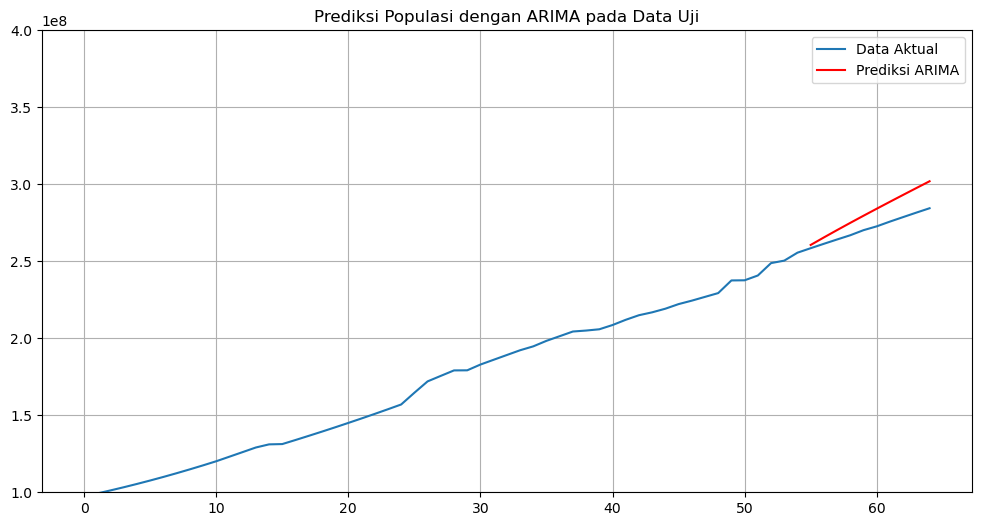

In [24]:


# Plot hasil akhir
plt.figure(figsize=(12, 6))
plt.ylim(100000000, 400000000)
plt.plot(df['Total'], label='Data Aktual')
plt.plot(forecast_df['original_pred'], label='Prediksi ARIMA', color='red')
plt.title('Prediksi Populasi dengan ARIMA pada Data Uji')
plt.legend()
plt.grid(True)
plt.show()

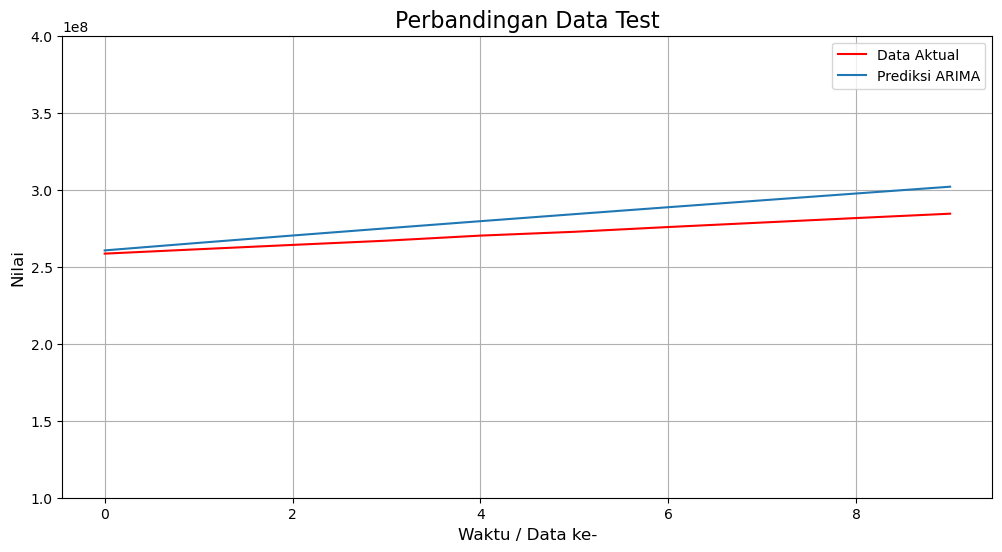

In [25]:
# Plot hasil akhir
plt.figure(figsize=(12, 6))
plt.plot(range(len(actual_test_values)), actual_test_values, label='Data Aktual', color='red')
plt.plot(range(len(forecast_df['original_pred'])), forecast_df['original_pred'], label='Prediksi ARIMA')
# 4. Menambahkan judul dan label
plt.ylim(100000000, 400000000)
plt.title('Perbandingan Data Test', fontsize=16)
plt.xlabel('Waktu / Data ke-', fontsize=12)
plt.ylabel('Nilai', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [15]:
forecast_df

,normalized_pred,original_pred
55,0.872552,0.872552
56,0.898666,0.898666
57,0.924216,0.924216
58,0.949300,0.949300
59,0.973999,0.973999
60,0.998378,0.998378
61,1.022494,1.022494
62,1.046392,1.046392
63,1.070110,1.070110
64,1.093678,1.093678
